## Классификация сервисов яндекс при помощи модели XGBoost

#### Библиотеки

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


print("Pandas version: ", pd.__version__)

import sys  

from sklearn.model_selection import train_test_split


Pandas version:  1.4.4


In [2]:
current_path = 'jupyter/ya'

# current_path = 'iter-20230609/by_balabanov'
df_final_filename = 'data/df_final.csv'

dfFinal = pd.read_csv(df_final_filename)

print('df_final: ', dfFinal.shape)
dfFinal

df_final:  (4693, 40)


,proto,packets_count,f_pkts_num,min_fiat,min_biat,flow_packets_per_second,f_min_pkt_size,f_max_pkt_size,b_min_pkt_size,b_max_pkt_size,...,type,total_fiat,pktlen_5,pktlen_6,pktlen_7,pktlen_9,tcp_psh_count,pktiat_5,pktlen_0,pktlen_4
0,6,10,4,0.000018,0.000013,0,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,10,4,0.000691,0.000010,1,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,10,4,0.001067,0.000013,1,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,10,4,0.001791,0.000009,0,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,10,4,0.000975,0.000011,0,66,583.0,66,1414.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,6,10,6,0.000724,0.000090,0,66,NaN,66,602.0,...,2,0.019945,NaN,66.0,NaN,NaN,6.0,0.000724,615.0,117.0
4689,6,10,4,0.001118,0.000036,0,66,NaN,66,1462.0,...,2,0.022579,NaN,66.0,NaN,NaN,5.0,0.000081,583.0,1462.0
4690,6,10,6,0.000354,0.000136,0,66,NaN,66,602.0,...,2,0.015337,NaN,66.0,NaN,NaN,6.0,0.000354,615.0,117.0
4691,6,10,6,0.000326,0.000036,0,66,NaN,66,602.0,...,2,0.015902,NaN,66.0,NaN,NaN,6.0,0.000389,615.0,117.0


In [3]:
dfFinal.dropna(axis=1,inplace=True)

In [4]:
y = dfFinal['type']
drop_col = ['type','proto','diag_step_fiat','diag_step_biat','diag_steps']
X  = dfFinal.drop(columns=drop_col)

In [5]:
X.columns

Index(['packets_count', 'f_pkts_num', 'min_fiat', 'min_biat',
       'flow_packets_per_second', 'f_min_pkt_size', 'b_min_pkt_size',
       'tcp_syn_count', 'tcp_ack_count', 'tcp_rst_count', 'tcp_fin_count',
       'tcp_urg_count', 'tcp_retr_count', 'pktiat_0', 'pktiat_1', 'pktiat_2',
       'pktiat_7', 'pktiat_9', 'pktlen_1', 'pktlen_8'],
      dtype='object')

#### Разобьем данные на подопытные и проверочные

In [6]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=None)

In [7]:
!pip3 install xgboost

## XGBoost

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_tree

##### Оценщиком выступит XGBoost

In [9]:
estimator = XGBClassifier(
    objective= 'multi:softmax',
    nthread=4,
    seed=42
)

##### ...со следующим набором параметров

In [10]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(20, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05, 0.2]
}

In [11]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 5,
    cv = 10,
    verbose=1
)

In [12]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=N

In [13]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [14]:
predictions_XGB = grid_search.predict(X_test)

In [15]:
print('\nXGBClassifier test accuracy:', accuracy_score(predictions_XGB, y_test))


XGBClassifier test accuracy: 0.9488636363636364


In [16]:
from sklearn.metrics import (confusion_matrix, accuracy_score, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

In [17]:
def plot_confusion_matrix(y_test, prediction, model_name, index=["0", "1", "2"], columns=["0", "1", "2"]):
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index, columns)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, fmt='g', annot_kws={"size": 10})
    plt.title(model_name+'\nAccuracy:{0:.4f}'.format(accuracy_score(y_test, prediction)))
    plt.ylabel('True Label', fontsize=1)
    plt.show()


def display_confusion_matrix(y_test, prediction, display_labels=["0", "1"]):
    cm = confusion_matrix(y_test, prediction)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_display.plot()
    plt.show()


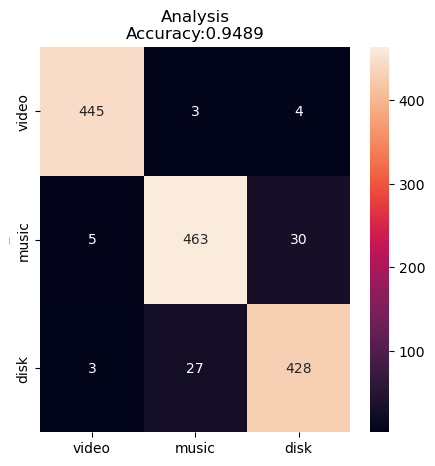

In [18]:
import seaborn as sns
plot_confusion_matrix(y_test, predictions_XGB.round(), "Analysis", index=["video", "music", "disk"], columns=["video", "music", "disk"])

In [19]:
# Make sure to average feature importances! 
feature_importances = grid_search.best_estimator_.feature_importances_ / 2
feature_importances = pd.DataFrame({'feature': list(X.columns),
                                    'importance': feature_importances}
                                  ).sort_values('importance', ascending = False)

feature_importances.head(10)

,feature,importance
14,pktiat_1,0.199971
4,flow_packets_per_second,0.095374
15,pktiat_2,0.060383
1,f_pkts_num,0.053201
19,pktlen_8,0.029999
16,pktiat_7,0.021121
3,min_biat,0.017487
17,pktiat_9,0.012772
2,min_fiat,0.009692
12,tcp_retr_count,0.000000
